In [2]:
# IPython magic to import matplotlib and plot inline
%matplotlib inline

In [9]:
# Path settings
import os
# we use a relative path here, you can also specify an absolute path for your system
out_path = "output/03_eigenvalues"
os.makedirs(out_path, exist_ok=True)

# Computing Eigenvalues in UFL

As discussed [here](https://fenicsproject.org/qa/12281/eigenvalues-eigenvectors-stress-strain-tensor-element-level/), [UFL](https://fenics.readthedocs.io/projects/ufl/en/latest/) does not provide operators fof computing Eigenvalues.
However, in order to formulate e.g. strain-energy potentials in function of the stretch ratios $\lambda_i$, UFL compatible expressions are required, not a numerical solution. 

The Eigenvalue problem can be solved by finding the roots of the characteristic polynomial. 
Here we look at a general solution for 2x2 matrices and a solution for symmetric, positive definite 3x3 matrices.

## 2x2 matrices

For 2x2 matrices, finding the roots corresponds to solving the quadratic equation. 
This solution is taken from [here](https://fenicsproject.org/qa/12281/eigenvalues-eigenvectors-stress-strain-tensor-element-level/).


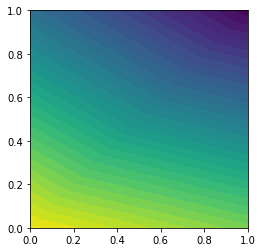

In [3]:
import fenics as fe
import sympy as sp
import ufl


mesh = fe.UnitSquareMesh(1, 1)
V = fe.VectorFunctionSpace(mesh, 'CG', 2)
u = fe.interpolate(fe.Expression(('x[0]', 'x[0]*x[1]'), degree=2), V)

F = fe.Identity(2) + fe.grad(u)
C = F*F.T

# Eigenvalues are roots of characteristic polynomial
# e**2 - tr(A)*e + det(A) = 0
def eig_plus(A): 
    return (fe.tr(A) + fe.sqrt(fe.tr(A)**2-4*fe.det(A)))/2
def eig_minus(A): 
    return (fe.tr(A) - fe.sqrt(fe.tr(A)**2-4*fe.det(A)))/2

def eig_vecmat_(A):
    lambdap = eig_plus(A)
    lambdan = eig_minus(A)
    a = A[0,0]
    b = A[0,1]
    c = A[1,0]
    d = A[1,1]
    if c != 0:
       Eigvecmat = [[lambdap-d,lambdan-d],[c,c]]
    elif b != 0:
         Eigvecmat = [[b,b],[lambdap-a,lambdan-a]]
    elif b == 0 & c == 0:
         Eigvecmat = [[1,0],[0,1]]    
    return Eigvecmat


def eig_vecmat(A):
    lambdap = eig_plus(A)
    lambdan = eig_minus(A)
    a = A[0,0]
    b = A[0,1]
    c = A[1,0]
    d = A[1,1]

    return fe.conditional(ufl.ne(c, 0),
                       fe.as_matrix(((lambdap-d,lambdan-d), (c,c))),
                       fe.conditional(ufl.ne(b, 0),
                                   fe.as_matrix(((b,b), (lambdap-a,lambdan-a))),
                                   fe.Identity(2)))

# Check
S = fe.FunctionSpace(mesh, 'CG', 2)
T = fe.TensorFunctionSpace(mesh, 'CG', 2)
f0 = fe.project(eig_vecmat(C),T) 
fe.plot(f0[0,1])  

## 3x3 matrices

Finding a solution for general 3x3 matrices is procedure is more complicated.

We could for example derive the analytic expression for the eigenvales using [sympy](https://www.sympy.org/en/index.html) and 'translate' into UFL, as outlined [here](https://fenicsproject.org/qa/13600/possible-perform-spectral-decomposition-current-operators/) for the case of 2x2 matrices. 
However, for general 3x3 matrices, these expressions contain complex numbers, which UFL is not able to deal with.

Here we propose a solution for symmetric, positive definite 3x3 matrices based on [this paper](https://pdfs.semanticscholar.org/8ab1/9ef9ad8f770a85c6283fc37ed6d11ae0eaae.pdf).



### UFL compatible implementation

In [4]:
import numpy as np
import fenics as fe
# computes Eigenvalues of 3D positive definite symmetric matrix

# Invariants 
def I1(T):
    return fe.tr(T)

def I2(T):
    t1 = T[0,0]*T[1,1] + T[0,0]*T[2,2] + T[1,1]*T[2,2]
    t2 = T[0,1]*T[0,1] + T[0,2]*T[0,2] + T[1,2]*T[1,2]
    return t1 - t2

def I3(T):
    return fe.det(T)

def v(T):
    return (I1(T)/3.)**2 - I2(T)/3.

def s(T):
    return (I1(T)/3.)**3 - I1(T)*I2(T)/6. + I3(T)/2.

def phi(T):
    arg = s(T)/v(T)*fe.sqrt(1./v(T))
    # numerical issues if arg~0 -> https://fenicsproject.org/qa/12299/nan-values-when-computing-arccos-1-0-bug/
    arg_cond = fe.conditional( fe.ge(arg,  1-fe.DOLFIN_EPS),  
                                     1-fe.DOLFIN_EPS, 
                                     fe.conditional( fe.le(arg, -1+fe.DOLFIN_EPS), -1+fe.DOLFIN_EPS, arg ))
    return fe.acos(arg_cond)/3.


In [5]:
# eigen values

def eigen_value(T, i):
    if i==1:
        ev =  I1(T)/3. + 2*fe.sqrt(v(T))*fe.cos(phi(T))
    elif i==2:
        ev =  I1(T)/3. - 2*fe.sqrt(v(T))*fe.cos(fe.pi/3. + phi(T))
    elif i==3:
        ev =  I1(T)/3. - 2*fe.sqrt(v(T))*fe.cos(fe.pi/3. - phi(T))
    return ev

In [6]:
# eigen vectors

def eigen_vector(T, i):
    eval_i = eigen_value(T, i)
    A = T[0,0] - eval_i
    B = T[1,1] - eval_i
    C = T[2,2] - eval_i
    
    evec_ix = (T[0,1]*T[1,2] - B*T[0,2]) * (T[0,2]*T[1,2] - C*T[0,1]) # - C*T[0,1] -> not fully typed in paper, there might be an error!
    evec_iy = (T[0,2]*T[1,2] - C*T[0,1]) * (T[0,2]*T[0,1] - A*T[1,2]) 
    evec_iz = (T[0,1]*T[1,2] - B*T[0,2]) * (T[0,2]*T[0,1] - A*T[1,2]) 
    
    evec = fe.as_vector( (evec_ix, evec_iy, evec_iz) )
    
    evec_norm = evec / fe.sqrt(fe.inner(evec,evec))
    return evec_norm
    

### Examples & comparison to numerical solution

In [7]:
#=== SOLUTION FROM NUMERICAL DIAGONALIZATION

import numpy as np

M = np.array([[2.,  1.,  4.], 
              [1.,  10., -1.], 
              [4., -1.,  10.]])

# M = np.array([[1.25126989, 0.1037006 , 0.1037006],
#               [0.1037006 , 0.97212285, 0.00190465], 
#               [0.1037006 , 0.00190465, 0.97212285]])

# M = np.array([[ 1.23034477e+00, -3.67293877e-07, -3.67293877e-07],
#               [-3.67293877e-07,  9.19800774e-01, -2.21675491e-07], 
#               [-3.67293877e-07, -2.21675491e-07,  9.19800774e-01]])

# M = np.array([[1., 0, 0], 
#               [0, 1., 0], 
#               [0, 0, 1.]])

evals, evecs = np.linalg.eig(M)
print("- is symmetric:    ", np.allclose(M, M.T, rtol=1e-5, atol=1e-8))
print("- is pos definite: ", np.all(evals > 0))

idx_sorted = np.argsort(evals)[::-1]
evals = evals[idx_sorted]
evecs = evecs[idx_sorted]

for i in range(0,3):
    print("---")
    print("- eigenvalue %i:       "%i, evals[i])
    print("- eigenvector %i:      "%i, evecs[:,i])
    print("- eigenvector %i norm: "%i, np.linalg.norm(evecs[:,i]))



- is symmetric:     True
- is pos definite:  True
---
- eigenvalue 0:        11.8309518948
- eigenvector 0:       [-0.13207861 -0.38507201  0.91338644]
- eigenvector 0 norm:  1.0
---
- eigenvalue 1:        10.0
- eigenvector 1:       [ 0.30604959 -0.89228022 -0.33191814]
- eigenvector 1 norm:  1.0
---
- eigenvalue 2:        0.169048105155
- eigenvector 2:       [-0.94280904 -0.23570226 -0.23570226]
- eigenvector 2 norm:  1.0


In [10]:
#=== SOLUTION USING UFL

T = fe.as_matrix(M)

xdmffile = fe.XDMFFile(os.path.join(out_path, 'eval_evec_test.xdmf'))
xdmffile.parameters["flush_output"] = True
xdmffile.parameters["functions_share_mesh"] = True

mesh = fe.BoxMesh(fe.Point(0,0,0),fe.Point(10.0,1,1),100,10,10)
Feval = fe.FunctionSpace(mesh, 'P', 1)
Fevec = fe.VectorFunctionSpace(mesh, 'P', 1)

evals_ufl = []
evecs_ufl = []

for i in [1,2,3]:
    eval_i = eigen_value(T, i)
    eval_field = fe.project(eval_i, Feval)
    eval_field.rename("lambda_%i"%i, "")
    evals_ufl.append(eval_field)
    xdmffile.write(eval_field,0)
    
    evec_i = eigen_vector(T , i)
    evec_field = fe.project(evec_i, Fevec)
    evec_field.rename("ev_%i"%i, "")
    evecs_ufl.append(evec_field)
    xdmffile.write(evec_field,0)

xdmffile.close()


Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [11]:
p = (5,0,0)

for i in range(0,3):
    print('---')
    print("- eigenvalue %i:       "%i, evals_ufl[i](p))
    print("- eigenvector %i:      "%i, evecs_ufl[i](p))
    print("- eigenvector %i norm: "%i, np.linalg.norm(evecs_ufl[i](p)))

print("- ev1 . ev2: ",np.dot(evecs_ufl[0](p), evecs_ufl[1](p)) )
print("- ev1 . ev3: ",np.dot(evecs_ufl[0](p), evecs_ufl[2](p)) )
print("- ev2 . ev3: ",np.dot(evecs_ufl[1](p), evecs_ufl[2](p)) )

---
- eigenvalue 0:        11.8309518948
- eigenvector 0:       [-0.33191814  0.30604959 -0.89228022]
- eigenvector 0 norm:  1.0
---
- eigenvalue 1:        10.0
- eigenvector 1:       [ 0.23570226  0.94280904  0.23570226]
- eigenvector 1 norm:  1.0
---
- eigenvalue 2:        0.169048105155
- eigenvector 2:       [ 0.91338644 -0.13207861 -0.38507201]
- eigenvector 2 norm:  1.0
- ev1 . ev2:  9.74220704109e-15
- ev1 . ev3:  -1.88737914186e-15
- ev2 . ev3:  -4.05231403988e-15


- Eigenvalues are computed correctly
- Eigenvectors are somewhat off ... the UFL soluting implemented here leads to a sign ambiguity according to the [paper](https://pdfs.semanticscholar.org/8ab1/9ef9ad8f770a85c6283fc37ed6d11ae0eaae.pdf), and there is a typo in computation of ev1. REQUIRES MORE TESTING!
- BUT, we are mostly interested in Eigenvalue computation!

NOTE:
- This approach does not work if the matrix is already diagonalized -> try with the identity matrix for example
- In this case, the term `v` becomes 0, which results in 'division by zero' in `phi`. 